### Natural Language Processing Project: "First Take"

MSDS NLP

Kishan Panchal

<img src="../presenters.jpg">

This project aims to see if we can distinguish between the tweets of Stephen A. Smith (left) and Skip  Bayless (right) and model the topics that they tweet about as well, who are two prominent sports debaters. They used to work together on a show called "First Take" on ESPN before leading their own sports debate shows. Since they work in the media, both are known for their strong opinions and exaggerations, and now that they do no directly debate with each other, some of their opinions are very similar, and they both comment on recent sports news. Thus, it is interesting to take their tweets and see if we can distinguish between the two.

### Data Acquisition

To acquire the data, I used the the Twitter teepy API to request the most recent 3,200 tweets for both Stephen A. Smith (@stephenasmith) and Skip Bayless (@RealSkipBayless). The earliest date for a tweet was November 3, 2016 for Stephen A. and September 17, 2017 for Skip and the most recent date is May 31, 2018 for both people. The script is included within another file. After obtaining the data for both people, I combined it together and labeled tweets by Stephen A. and Skip so that we can distnguish between them.

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [26]:
import pandas as pd   
import numpy as np
import re
from nltk.corpus import stopwords 
from collections import Counter
import pyLDAvis.gensim
from gensim import corpora, models, similarities
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import PCA
from display_cm import *

pyLDAvis.enable_notebook()
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'

In [27]:
smith = pd.read_csv('../Data/stephenasmith_tweets.csv')
smith['label'] = 0

skip = pd.read_csv('../Data/RealSkipBayless_tweets.csv')
skip['label'] = 1

In [28]:
smith.head(4)

,id,created_at,text,label
0,1002000207343534080,2018-05-31 01:34:00,After Dark Podcast: Reasons why Colangelo dese...,0
1,1001920206288060417,2018-05-30 20:16:06,RT @FirstTake: The stage is finally set. Join ...,0
2,1001868088353181697,2018-05-30 16:49:00,My Lord!!! We're talking burner accounts. #ESP...,0
3,1001665250985463809,2018-05-30 03:23:00,Stephen A. Smith After Dark Podcast: The @Warr...,0


In [29]:
skip.head(4)

,id,created_at,text,label
0,1001998406540292097,2018-05-31 01:26:51,I've got a funny feeling about this Finals.,1
1,1001908778441236482,2018-05-30 19:30:42,Today's Undisputed podcast: https://t.co/OA90o...,1
2,1001839619162296322,2018-05-30 14:55:53,Are the Lakers getting serious about drafting ...,1
3,1001836769703223296,2018-05-30 14:44:33,"The Warriors are vulnerable. More @Undisputed,...",1


In [9]:
smith_df = smith[['text', 'label']]
skip_df = skip[['text', 'label']]

train = pd.concat( [smith_df, skip_df] ).reset_index()

In [10]:
train['text'][0]

'After Dark Podcast: Reasons why Colangelo deserves the benefit of the doubt. @IsiahThomas joins with a fantastic MJ v. LeBron argument. https://t.co/1sy8aKjl30'

### Data Processing

Now we need to clean the tweet data. We can do this by removing non-letter characters, getting rid of any links mentioned in the tweets, converting words to lower case, removing stop words, and removing words from other_stops, which are words that appear in tweets that make it easier to identify the tweet owner. Stemming ends up removing some of the meaning of words in this case and thus was not used.

These include twitter handles of cohosts and mentions of the names of the TV shows and companies that Stephen A. and Skip work for.

In [11]:
other_stops = ['stephen', 'a.', 'smith', 'skip bayless', '@undisputed.',\
               '@undisputed', '9:30','rt','&amp', '&amp;', '@undisputed:', \
               '@firsttake', '@firsttake:', 'et.', 'fs1', 'shannon sharpe',\
               'stephen a.', 'a. smith', 'a', ',', '@stephenasmith', '@ShannonSharpe',\
               '@RealSkipBayless', 'undisputed', '-', 'after', 'dark', 'first', 'take',
               '@maxkellerman', 'espn', 'podcast', 'podcast:', '.@stephenasmith',\
               '@undisputed,', '...', 'vs', '--', 'firsttake', 'stephenasmith',
               'amp', 'fs', 'et', 'maxkellerman', 'ShannonSharpe', 'facebook',
               'max', 'kellerman', 'shannon', 'sharpe']

In [12]:
def process_tweet(tweet):

    no_links = re.sub(r'(www|http:|https:)+[^\s]+[\w]', ' ', str(tweet))
    
    letters_only = re.sub(r'[^a-zA-Z]', ' ', str(no_links)) 
        
    words = letters_only.lower().split()
    
    words = [w for w in words if w not in set(stopwords.words("english"))] 
    
    words = [w for w in words if w not in set(other_stops)]
    
    words = [w for w in words if len(w) > 1]
    
    return " ".join(words)

In [13]:
print('Original Tweet: ' + '%s' %(train['text'][3]))

print('\nCleaned tweet: ' + '%s' %(process_tweet(train['text'][3])))

Original Tweet: Stephen A. Smith After Dark Podcast: The @Warriors win over the #Rockets, and I'm also not impressed with @KingJames despite his success this year. https://t.co/782nywEFOK

Cleaned tweet: warriors win rockets also impressed kingjames despite success year


In [14]:
train['text'] = train['text'].apply(process_tweet)

In [15]:
train.sample(5)

,index,text,label
4910,1685,brice butler cowboys best wide receiver joins ...,1
4181,956,today go live talk nfl free agency join hazel,1
955,955,thankful patriots came back jaguars gave us ma...,0
2811,2811,like said many occasions pure talent qb positi...,0
1020,1020,final play lucky,0


### Exploratory Data Analysis

#### Most Frequent Words Used

What are the top 25 most common words used by Stephen A. Smith?

In [16]:
smith_tokens = " ".join(train[train['label']==0]['text']).split(" ")
smith_dict = Counter(smith_tokens)

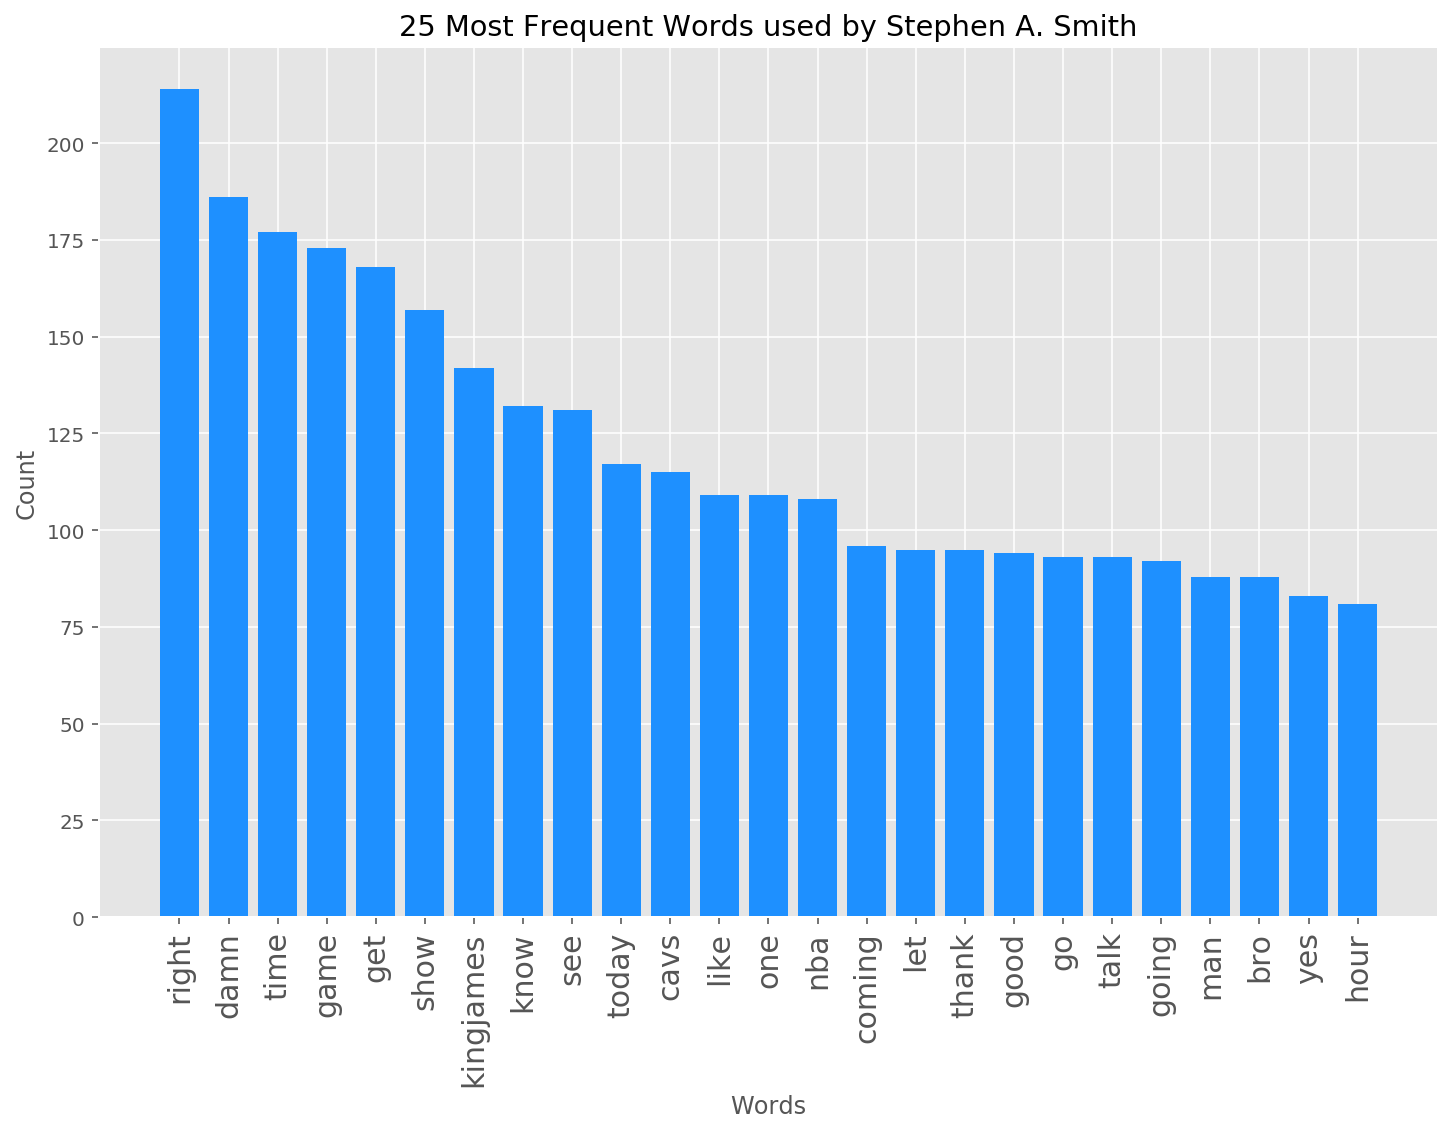

In [17]:
labels, values = zip(*smith_dict.most_common(25))

plt.figure(figsize=(12,8))
plt.bar(labels, values, color = 'dodgerblue')
plt.xticks(labels, rotation = 90, size=15)
plt.xlabel('Words', size=12)
plt.ylabel('Count', size=12)
plt.title('25 Most Frequent Words used by Stephen A. Smith')
plt.show()

What are the 25 most common words used by Skip Bayless?

In [18]:
skip_tokens = " ".join(train[train['label']==1]['text']).split(" ")
skip_dict = Counter(skip_tokens)

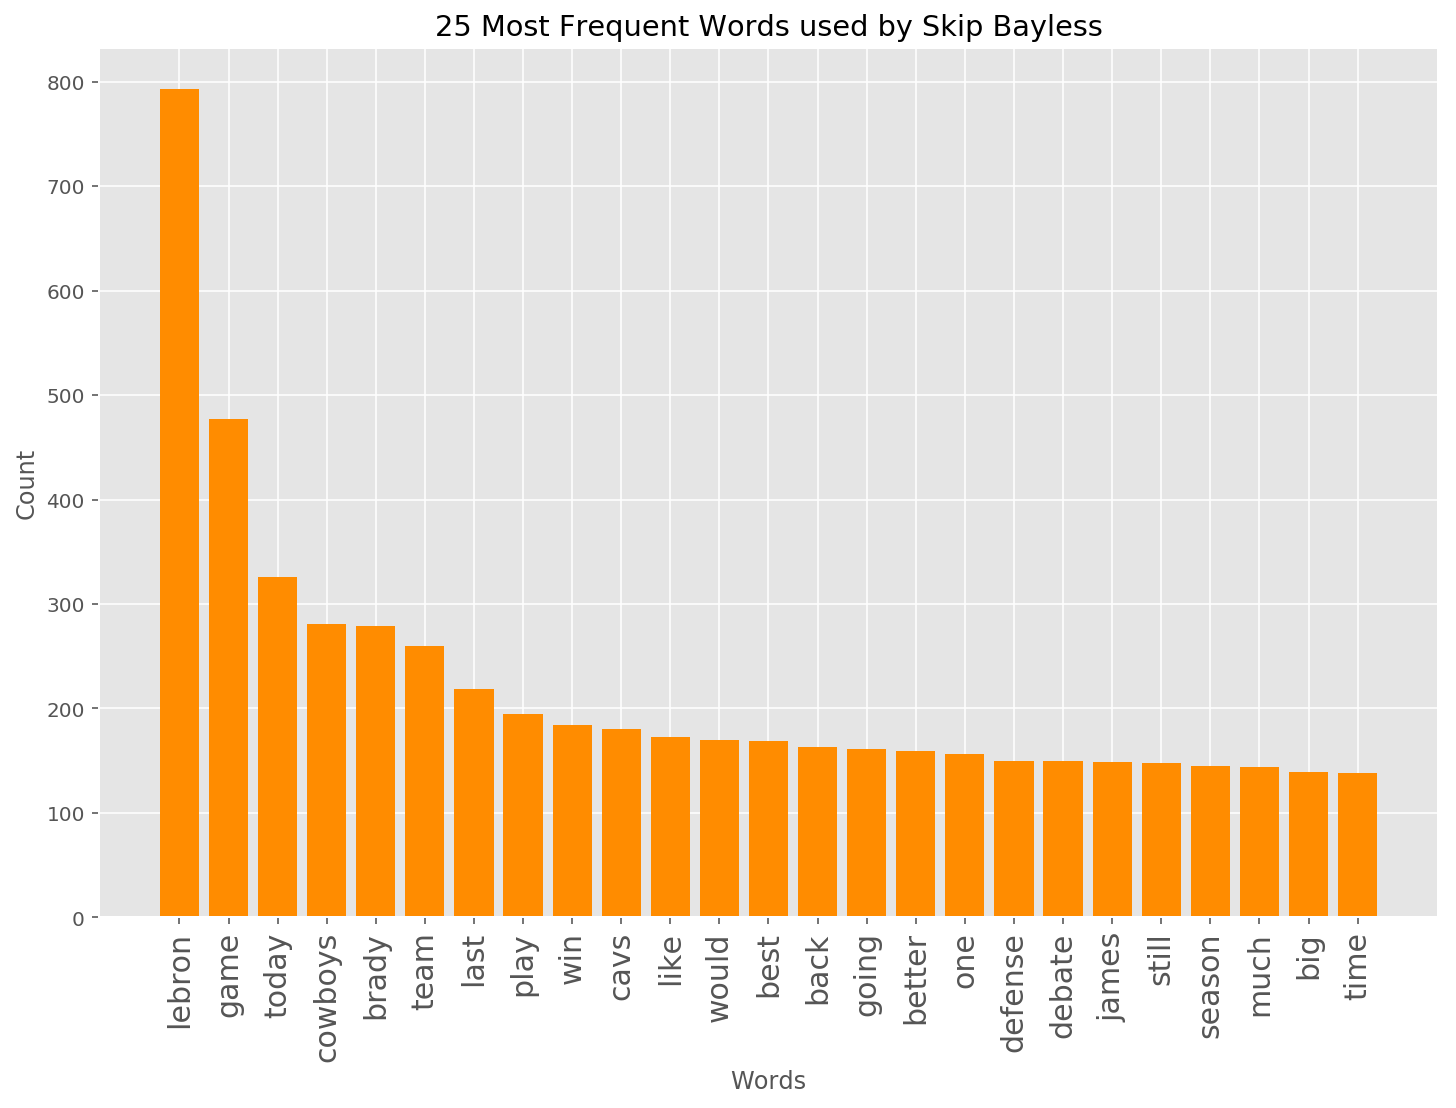

In [19]:
labels, values = zip(*skip_dict.most_common(25))

plt.figure(figsize=(12,8))
plt.bar(labels, values, color = 'darkorange')
plt.xticks(labels, rotation = 90, size=15)
plt.xlabel('Words', size=12)
plt.ylabel('Count', size=12)
plt.title('25 Most Frequent Words used by Skip Bayless')
plt.show()

From the two graphs above, it looks like Skip refers to LeBron James (lebron), the Dallas Cowboys (cowboys), and the Cleveland Cavaliers (cavs) the most in his tweets whereas Stephen A. uses the word 'damn' quite frequently and also mentions LeBron James (kingjames) and the Cleveland Cavaliers (cavs) as well. These plots also depend on the fact that LeBron James routinely breaks NBA records, so it makes sense that he would be mentioned quite often by individuals working in sports debate.

#### Topic Modeling

Topic modeling will help us get a sense of the topics that these sports personalities have talked about from their tweets. Let's check out the five main topics their tweets were about.

Each topic is represented by a circle, and the area of each circle represents the prevalence of a topic, and the numbers in ascending order represent the largest areas. The distance between circles represents topic similarity. Clicking on a circle will give you the most revelant words in a topic. The red bar is the term frequency in this topic, and the blue bar is the overall term frequency. Sliding the lambda slider to 0 results in terms that are mostly only relevant to the topic itself.

In [20]:
all_texts = [ text.split(' ') for text in train['text'] ]
dictionary = corpora.Dictionary(all_texts)

corpus = [dictionary.doc2bow(text) for text in all_texts]
ldamodel = models.ldamodel.LdaModel(corpus, num_topics=5, id2word = dictionary)

viz = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.047851  0.052528       1        1  23.201225
0      0.005174  0.064530       2        1  21.562958
1      0.024065 -0.165431       3        1  21.073423
4     -0.176344  0.013308       4        1  17.710524
3      0.099254  0.035065       5        1  16.451866, topic_info=     Category        Freq      Term       Total  loglift  logprob
term                                                             
1824  Default  232.000000    debate  232.000000  30.0000  30.0000
419   Default  609.000000     today  609.000000  29.0000  29.0000
3138  Default  279.000000       dak  279.000000  28.0000  28.0000
1381  Default  583.000000   cowboys  583.000000  27.0000  27.0000
2109  Default  158.000000     aaron  158.000000  26.0000  26.0000
622   Default  155.000000      live  155.000000  25.0000  25.0000
2113  Default  130.000000   rodgers  130.000000  24.0000  24.0000
13    Default  141.000000      join  141.000000  23.0000  23.0000
1276  Default  172.000000       dez  172.000000  22.0000  22.0000
3025  Default  122.000000       cam  122.000000  21.0000  21.0000
18    Default  241.000000        us  241.000000  20.0000  20.0000
1163  Default  106.000000      melo  106.000000  19.0000  19.0000
247   Default   82.000000      russ   82.000000  18.0000  18.0000
3412  Default  100.000000      rams  100.000000  17.0000  17.0000
351   Default  133.000000      late  133.000000  16.0000  16.0000
6732  Default  100.000000     odell  100.000000  15.0000  15.0000
430   Default  347.000000     brady  347.000000  14.0000  14.0000
2060  Default   79.000000      eric   79.000000  13.0000  13.0000
2000  Default  146.000000      pass  146.000000  12.0000  12.0000
3012  Default   60.000000   deshaun   60.000000  11.0000  11.0000
3315  Default   60.000000    throws   60.000000  10.0000  10.0000
3979  Default   57.000000     wentz   57.000000   9.0000   9.0000
3139  Default   65.000000  prescott   65.000000   8.0000   8.0000
582   Default  141.000000      lost  141.000000   7.0000   7.0000
100   Default  600.000000      game  600.000000   6.0000   6.0000
85    Default  166.000000      half  166.000000   5.0000   5.0000
595   Default  105.000000    played  105.000000   4.0000   4.0000
2499  Default  105.000000      easy  105.000000   3.0000   3.0000
291   Default  128.000000       mvp  128.000000   2.0000   2.0000
1373  Default   55.000000     shots   55.000000   1.0000   1.0000
...       ...         ...       ...         ...      ...      ...
353    Topic5   25.431969      bout   30.449383   1.6247  -6.0381
7115   Topic5   28.441223       yds   36.056519   1.5675  -5.9263
291    Topic5   68.726425       mvp  128.924286   1.1756  -5.0440
600    Topic5   35.785931    pretty   52.156597   1.4280  -5.6965
700    Topic5   50.886181     jerry   90.776100   1.2259  -5.3445
513    Topic5   67.929932    eagles  143.839920   1.0545  -5.0556
5789   Topic5   29.933863    carson   40.933605   1.4918  -5.8751
1381   Topic5  154.139847   cowboys  583.291382   0.4739  -4.2362
1276   Topic5   67.674789       dez  172.765594   0.8675  -5.0594
3138   Topic5   81.028244       dak  279.067657   0.5681  -4.8793
701    Topic5   28.947214     jones   40.336983   1.4729  -5.9086
520    Topic5   37.746826      east   68.524254   1.2084  -5.6432
2673   Topic5   39.973351    dallas   77.310707   1.1451  -5.5859
184    Topic5   69.213699       nfl  249.991989   0.5205  -5.0369
140    Topic5   58.033691      good  177.658066   0.6859  -5.2131
596    Topic5   40.834484      beat   88.524399   1.0310  -5.5646
419    Topic5   91.800018     today  609.464355  -0.0882  -4.7545
24     Topic5   54.118454      also  178.260956   0.6127  -5.2829
1885   Topic5   49.175228   without  140.871307   0.7523  -5.3787
8      Topic5   86.306816    lebron  705.026184  -0.2956  -4.8162
31     Topic5   60.621136       win  290.758514   0.2369  -5.1695
294    Topic5  

From the above visualization, we notice that Topic 1 is primarily basketball-related, as it contains many references to LeBron James, Lonzo Ball, Magic Johnson, LaVar Ball, Carmelo Anthony, and the Oklahoma City Thunder.

Topic 2 seems like more of a mix of basketball and football, and Topic 3 seems like a primarily football topic with references to Tom Brady, Dez Bryant, the New England Patriots, DeShaun Jackson, the Dallas Cowboys, Ezekeiel Elliot, Bill Belichick, Baker Mayfield, and Rob Gronkowski. Topic 4 is also mainly football-focused, and Topic 5 is football and baseball-related.

Thus, the two main topics that Stephen A. Smith and Skip Bayless tweeted about were basketball and football.

### Modeling 

We will model this data using four machine learning algorithms: Random Forest, Logistic Regression, Multinomial Naive Bayes, and the Stochastic Gradient Descent (SGD) Classifier. 

In training these models, we will utilize Grid Search Cross Validation on each of these models and use the cross-validated F1-Score as our evaluation metric to decide which one of these models is optimal.

Because our text data needs to be converted into numerical format before we model it, we will use the TFIDF (term frequency inverse document frequency) vectorizer, which creates tokens based on word frequencies but reduces the weight of a word by the frequency of that word in the corpus.

In [21]:
X=np.array(train['text'])
y=np.array(train['label'])

In [22]:
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None, max_features = 20000) 

In [23]:
train_data_features = vectorizer.fit_transform(X)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(train_data_features, y, test_size=0.15, random_state=42)

In [25]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(5466, 8719) (5466,) (965, 8719) (965,)


### Random Forest

The hyperparameters of the Random Forest model we are going to tune include: 
 - n_estimators - this is the numbers of trees that will be used in the model
 - max_features -

In [31]:
forest = RandomForestClassifier(n_estimators = 100) 
forest = forest.fit( X_train, y_train )

In [33]:
test_preds = forest.predict(X_test)
np.sum((test_preds==y_test))/len(test_preds)

0.8652849740932642

### Logistic Regression

The hyperparameters of the Logistic Regression model we are going to tune include: 
 - feature1 - this is 
 - feature2 -

### Multinomial Naive Bayes

The hyperparameters of the Multinomial Naive Bayes model we are going to tune include: 
 - feature1 - this is 
 - feature2 -

In [34]:
clf = MultinomialNB()
clf = clf.fit( X_train, y_train )

In [35]:
train_result2 = clf.predict(X_test)
np.sum((train_result2==y_test))/len(train_result2)

0.8932642487046633

### SGD Classifier

The hyperparameters of the SGD Classifier model we are going to tune include: 
 - feature1 - this is 
 - feature2 -

In [36]:
clf_sgd = SGDClassifier(loss='perceptron', penalty='l2', alpha=6e-4, random_state=42)
clf_sgd = clf_sgd.fit( X_train, y_train )

In [37]:
train_result3 = clf_sgd.predict(X_test)

In [38]:
np.sum((train_result3==y_test))/len(train_result3)

0.8756476683937824

In [40]:
confusion_matrix(y_test, train_result2)

array([[424,  83],
       [ 20, 438]])

In [47]:
def display_evaluation_metrics(true_labels, predicted_labels, positive_class=1):
    
    print( 'Accuracy:', np.round(
                        metrics.accuracy_score(true_labels, 
                                               predicted_labels),
                        2))
    print( 'Precision:', np.round(
                        metrics.precision_score(true_labels, 
                                               predicted_labels,
                                               pos_label=positive_class,
                                               average='binary'),
                        2))
    print( 'Recall:', np.round(
                        metrics.recall_score(true_labels, 
                                               predicted_labels,
                                               pos_label=positive_class,
                                               average='binary'),
                        2))
    print( 'F1 Score:', np.round(
                        metrics.f1_score(true_labels, 
                                               predicted_labels,
                                               pos_label=positive_class,
                                               average='binary'),
                        2))

In [99]:
def display_classification_report(true_labels, predicted_labels, classes=[1,0]):

    report = metrics.classification_report(y_true=true_labels, 
                                           y_pred=predicted_labels, 
                                           labels=classes) 
    print( report)

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


### Our best model is ___. Let's examine the cufusion matrix for it based on our hold out data.

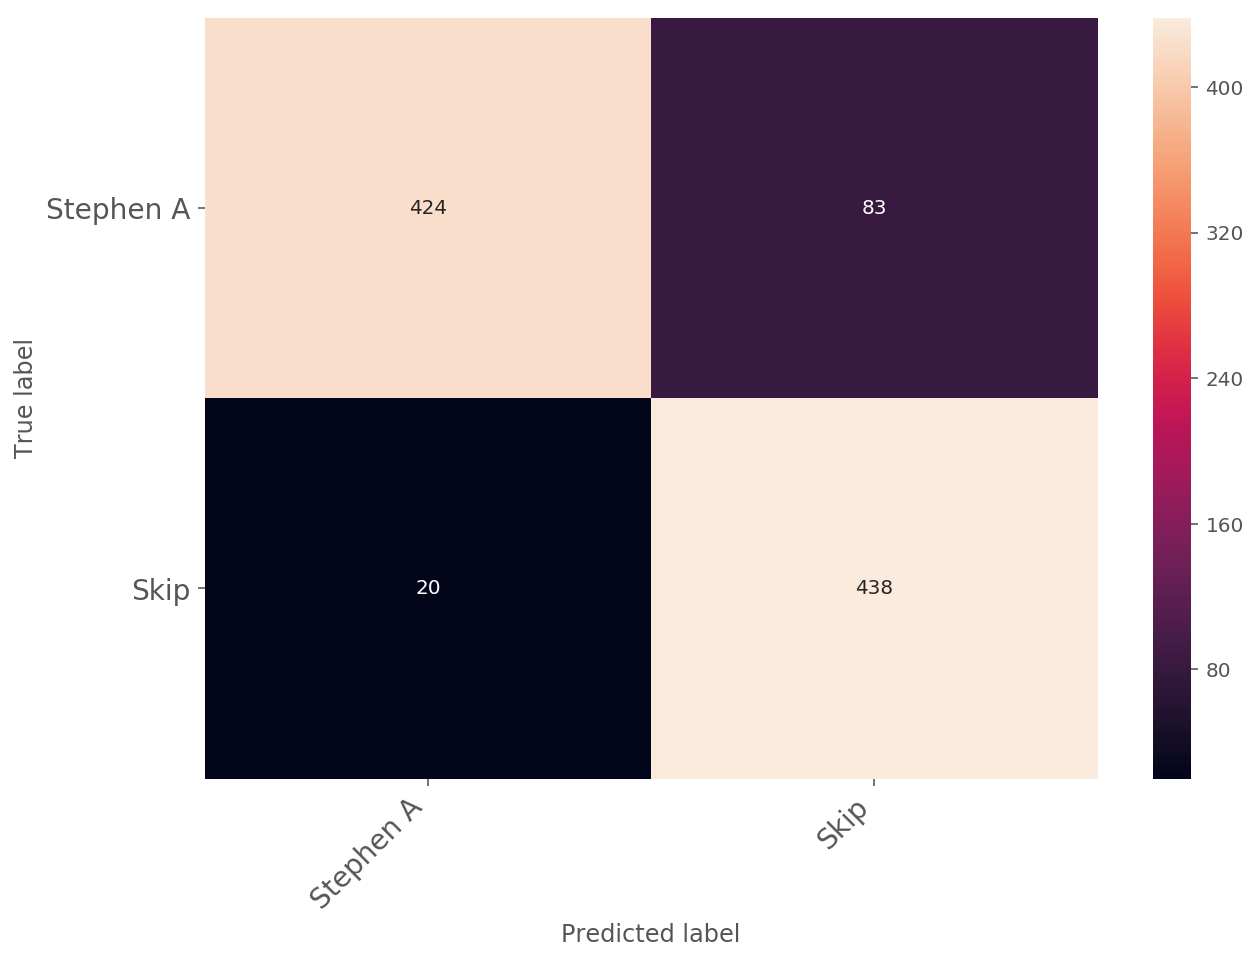

In [97]:
print_confusion_matrix( confusion_matrix(y_test, train_result2), class_names = ['Stephen A', 'Skip'])

In [85]:
display_evaluation_metrics(y_test, train_result2)

Accuracy: 0.89
Precision: 0.84
Recall: 0.96
F1 Score: 0.89


In [100]:
display_classification_report(y_test, train_result2)

             precision    recall  f1-score   support

          1       0.84      0.96      0.89       458
          0       0.95      0.84      0.89       507

avg / total       0.90      0.89      0.89       965



### References 

https://radimrehurek.com/gensim/tut1.html